# Vertical regridding and remapping of CMIP6 ocean data in the cloud
## C Spencer Jones, Julius Busecke, Takaya Uchida and Ryan Abernathey

In [1]:
#conda install xarray=0.15.0
#conda install -c conda-forge xarrayutils

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import matplotlib.pyplot as plt
import time

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')
df_sub = df.query("source_id == 'ACCESS-ESM1-5' and member_id=='r1i1p1f1' and table_id=='Omon' and (experiment_id=='ssp126' or experiment_id=='ssp585') and \
                            (variable_id=='thetao' or variable_id=='so')")

In [4]:
df_sub.zstore.values
my_values = df_sub.zstore.values

In [5]:
# get the path to a specific zarr store (ps)
zstore = my_values[0]
# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)
# open it using xarray and zarr
ds_so_ssp126 = xr.open_zarr(mapper, consolidated=True)

# get the path to a specific zarr store (ps)
zstore = my_values[1]
# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)
# open it using xarray and zarr
ds_thetao_ssp126 = xr.open_zarr(mapper, consolidated=True)

# get the path to a specific zarr store (ps)
zstore = my_values[2]
# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)
# open it using xarray and zarr
ds_so_ssp585 = xr.open_zarr(mapper, consolidated=True)

# get the path to a specific zarr store (ps)
zstore = my_values[3]
# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)
# open it using xarray and zarr
ds_thetao_ssp585 = xr.open_zarr(mapper, consolidated=True)


In [6]:
import gsw
dens126 = xr.apply_ufunc(gsw.density.sigma0, ds_so_ssp126['so'], ds_thetao_ssp126['thetao'],
                      dask='parallelized', output_dtypes=[float, ]
                     ).rename('dens').to_dataset()
dens585 = xr.apply_ufunc(gsw.density.sigma0, ds_so_ssp585['so'], ds_thetao_ssp585['thetao'],
                      dask='parallelized', output_dtypes=[float, ]
                     ).rename('dens').to_dataset()

In [7]:
#load prerequisites so that both methods are on a level playing field
dens126_cs=dens126.isel(i=slice(260,262),time=1031).load()
dens585_cs=dens585.isel(i=slice(260,262),time=1031).load()
ds_so_ssp126_cs=ds_so_ssp126.isel(i=slice(260,262),time=1031).load()
ds_so_ssp585_cs=ds_so_ssp585.isel(i=slice(260,262),time=1031).load()

In [8]:
dens126_xau=dens126_cs.assign_coords(lev_bounds=ds_thetao_ssp126.lev_bnds[:,1])
so126_xau=ds_so_ssp126_cs.assign_coords(lev_bounds=ds_so_ssp126.lev_bnds[:,1])
so126_xau['so']=so126_xau['so'].fillna(0)

dens585_xau=dens585_cs.assign_coords(lev_bounds=ds_thetao_ssp585.lev_bnds[:,1])
so585_xau=ds_so_ssp585_cs.assign_coords(lev_bounds=ds_so_ssp585.lev_bnds[:,1])
so585_xau['so']=so585_xau['so'].fillna(0)

# xarrayutils
First, we use xarrayutils to look at the salinity as a function of density

In [9]:
from xarrayutils.vertical_coordinates import conservative_remap
from xarrayutils.vertical_coordinates import linear_interpolation_regrid

In [10]:

t_vals = np.hstack([dens126_xau.dens.min().load().data[np.newaxis], np.arange(21.6,28, 0.1), dens126_xau.dens.max().load().data[np.newaxis]])
t_vals
# for now the results are ordered by the bin values. Since the temperature is decreasing, we need to flip the logical axis.
# We could also do that after the regridding, but this seems more elegant.
#t_vals = np.flip(t_vals)

temperature_values = xr.DataArray(t_vals, coords=[('t', t_vals)]) # define the new temperature grid

z_temp_bounds126 = linear_interpolation_regrid(dens126_xau.lev, dens126_xau.dens, temperature_values, z_bounds=dens126_xau.lev_bounds.swap_dims({'lev':"lev_bounds"}) ,target_value_dim='t', z_bounds_dim='lev_bounds')
z_temp_bounds585 = linear_interpolation_regrid(dens585_xau.lev, dens585_xau.dens, temperature_values, z_bounds=dens585_xau.lev_bounds.swap_dims({'lev':"lev_bounds"}) ,target_value_dim='t', z_bounds_dim='lev_bounds')


In [11]:

dens126_xau['dens']=dens126_xau['dens'].fillna(28.5)
dens585_xau['dens']=dens585_xau['dens'].fillna(28.5)

bounds_original = dens126_xau.lev_bounds[0:].swap_dims({'lev':"lev_bounds"}) 
bounds_new = xr.DataArray(np.arange(0,2020, 20), dims=['new_bounds'])

# now we can remap the tracer data again (at the moment the depth dimensions have to be explicitly defined).
ds_temp_cons126 = conservative_remap(so126_xau.so[1:,:,:].squeeze(),bounds_original, z_temp_bounds126.squeeze(),
                                   z_dim='lev', z_bnd_dim='lev_bounds', z_bnd_dim_target='regridded', mask=True) # the associated depth dimensions for each array
# # replace the new depth dimension values with the appropriate depth (here the middle of the temperature cell bounds)
t_vals = z_temp_bounds126.coords['regridded'].data
t_vals = 0.5 * (t_vals[1:] + t_vals[0:-1])

ds_temp_cons126.coords['remapped'] = xr.DataArray(t_vals, coords=[('remapped', t_vals)])


bounds_original = dens585_xau.lev_bounds[0:].swap_dims({'lev':"lev_bounds"}) 
bounds_new = xr.DataArray(np.arange(0,2020, 20), dims=['new_bounds'])

# now we can remap the tracer data again (at the moment the depth dimensions have to be explicitly defined).
ds_temp_cons585 = conservative_remap(so585_xau.so[1:,:,:].squeeze(),bounds_original, z_temp_bounds585.squeeze(),
                                   z_dim='lev', z_bnd_dim='lev_bounds', z_bnd_dim_target='regridded', mask=True) # the associated depth dimensions for each array
# # replace the new depth dimension values with the appropriate depth (here the middle of the temperature cell bounds)
t_vals = z_temp_bounds585.coords['regridded'].data
t_vals = 0.5 * (t_vals[1:] + t_vals[0:-1])

ds_temp_cons585.coords['remapped'] = xr.DataArray(t_vals, coords=[('remapped', t_vals)])


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/computation.py:1216: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/computation.py:1216: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])


In [12]:

start=time.time()
difference_xau=(ds_temp_cons585.mean('i')-ds_temp_cons126.mean('i')).load()
#plt.ylim(34,36)
end=time.time()
end-start

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


0.5036537647247314

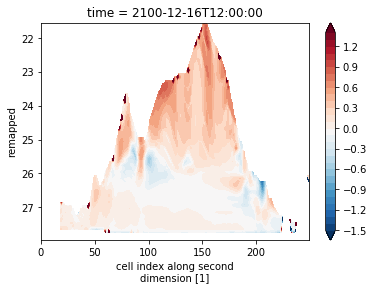

In [13]:
difference_xau[:250,:].plot.contourf(x='j',y='remapped',levels=np.arange(-1.5,1.5,0.1),cmap='RdBu_r')
plt.gca().invert_yaxis()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


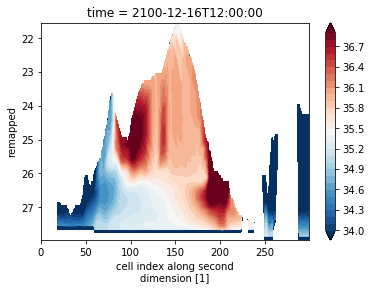

In [14]:
(ds_temp_cons126.mean('i')).plot.contourf(x='j',y='remapped',levels=np.arange(34,37,0.1),cmap='RdBu_r')
plt.gca().invert_yaxis()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


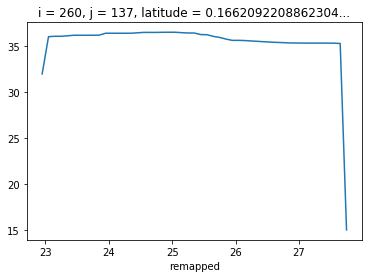

In [15]:
(ds_temp_cons126)[137,0,:].plot()

# xlayers
Now we reproduce this result with xlayers and compare the two

In [16]:
from xlayers import finegrid, layers
from xlayers.core import layers_numpy

In [17]:
dens126_xlay=dens126_cs.fillna(28.5).assign_coords(lev_bounds=ds_thetao_ssp126.lev_bnds)
dens585_xlay=dens585_cs.fillna(28.5).assign_coords(lev_bounds=ds_thetao_ssp585.lev_bnds)

In [18]:
def finegrid_metrics(levs,lev_bnds):
    drF = np.diff(lev_bnds,axis=1)
    drC = np.concatenate((np.array([levs[0]]),np.diff(levs,axis=0),np.array([lev_bnds[-1,-1]-levs[-1]])))
    return(drF,drC)

In [19]:
fine_drf,fine_drc = finegrid_metrics(dens585_xlay.lev.values,dens585_xlay.lev_bnds.values)
drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(fine_drf),np.squeeze(fine_drc),[fine_drf.size,20])
denslayers = np.hstack([dens126_xau.dens.min().load().data[np.newaxis], np.arange(21.6,28, 0.1), dens126_xau.dens.max().load().data[np.newaxis]])
v_lay1 = xr.apply_ufunc(layers_numpy, ds_so_ssp126_cs.so, dens126_xlay.dens,#.chunk({'time': 2})
                       kwargs={'thetalayers':denslayers,'mapfact':mapfact,
                               'mapindex':mapindex,'cellindex':cellindex,
                               'drf_finer':drf_finer},
                       dask='parallelized', 
                       input_core_dims=[['lev'],['lev']], output_core_dims=[['Tlev']],
                       output_dtypes=[float], output_sizes={'Tlev':denslayers.size}
                       )
v_lay1 = v_lay1.assign_coords({'Tlev':denslayers})


th_lay1 = xr.apply_ufunc(layers_numpy, xr.ones_like(ds_so_ssp126_cs.so), dens126_xlay.dens,#.chunk({'time': 2})
                       kwargs={'thetalayers':denslayers,'mapfact':mapfact,
                               'mapindex':mapindex,'cellindex':cellindex,
                               'drf_finer':drf_finer},
                       dask='parallelized', 
                       input_core_dims=[['lev'],['lev']], output_core_dims=[['Tlev']],
                       output_dtypes=[float], output_sizes={'Tlev':denslayers.size}
                       )
th_lay1 = th_lay1.assign_coords({'Tlev':denslayers})

fine_drf,fine_drc = finegrid_metrics(dens585_xlay.lev.values,dens585_xlay.lev_bnds.values)
drf_finer, mapindex, mapfact, cellindex = finegrid.finegrid(np.squeeze(fine_drf),np.squeeze(fine_drc),[fine_drf.size,20])
v_lay2 = xr.apply_ufunc(layers_numpy, ds_so_ssp585_cs.so, dens585_xlay.dens,#.chunk({'time': 2})
                       kwargs={'thetalayers':denslayers,'mapfact':mapfact,
                               'mapindex':mapindex,'cellindex':cellindex,
                               'drf_finer':drf_finer},
                       dask='parallelized', 
                       input_core_dims=[['lev'],['lev']], output_core_dims=[['Tlev']],
                       output_dtypes=[float], output_sizes={'Tlev':denslayers.size}
                       )
v_lay2 = v_lay2.assign_coords({'Tlev':denslayers})


th_lay2 = xr.apply_ufunc(layers_numpy, xr.ones_like(ds_so_ssp585_cs.so), dens585_xlay.dens,#.chunk({'time': 2})
                       kwargs={'thetalayers':denslayers,'mapfact':mapfact,
                               'mapindex':mapindex,'cellindex':cellindex,
                               'drf_finer':drf_finer},
                       dask='parallelized', 
                       input_core_dims=[['lev'],['lev']], output_core_dims=[['Tlev']],
                       output_dtypes=[float], output_sizes={'Tlev':denslayers.size}
                       )
th_lay2 = th_lay2.assign_coords({'Tlev':denslayers})

In [20]:
start=time.time()
difference_xlay=(((v_lay2)/(th_lay2)).mean('i')-((v_lay1)/(th_lay1)).mean('i')).load()
end=time.time()
end-start

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


0.010289669036865234

(28, 20)

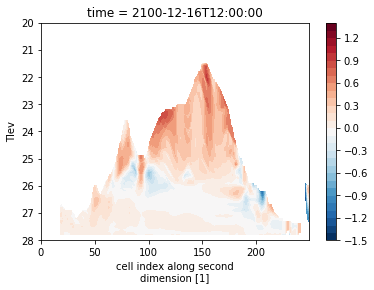

In [21]:
difference_xlay[:250,:].plot.contourf(x='j',y='Tlev',levels=np.arange(-1.5,1.5,0.1))#,levels=np.arange(-0.15,0.15,0.01))
plt.gca().invert_yaxis()
plt.ylim(28,20)

# 